# Configuring random forest classifiers
When training random forest classifiers for image segmentation two major aspects need to be configured: 1) which feature images (filters) should be used, and how deep should the decision trees be. In this notebook we will explore who these parameters can be inspected.

Read more:
* [scikit-learns page about feature selection](https://scikit-learn.org/stable/modules/feature_selection.html)

In [1]:
from skimage.io import imread, imsave
import pyclesperanto_prototype as cle
import numpy as np
import apoc
import matplotlib.pyplot as plt
import pandas as pd
import stackview
from skimage.data import human_mitosis

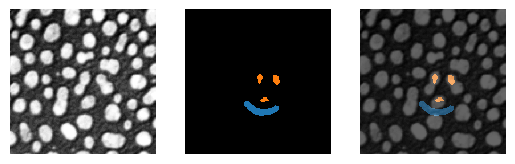

In [2]:
image = imread('data/blobs.tif')

manual_annotation = imread('data/blobs_annotations.tif')

fig, axs = plt.subplots(1,3)

stackview.imshow(image, plot=axs[0])
stackview.imshow(manual_annotation, labels=True, plot=axs[1])
stackview.imshow(image, plot=axs[2], continue_drawing=True)
stackview.imshow(manual_annotation, labels=True, plot=axs[2], alpha=0.6)

## Training - with too many features
We now train a object segmenter and provide many features. We also need to provide parameters to configure deep decision trees and many trees. This is necessary so that the next steps, deriving statistics, has enough statistical power.
Afterwards, we take a look at the result for a quick sanity check.

In [3]:
features = apoc.PredefinedFeatureSet.small_dog_log.value + " " + \
           apoc.PredefinedFeatureSet.medium_dog_log.value + " " + \
           apoc.PredefinedFeatureSet.large_dog_log.value
features

'original gaussian_blur=1 difference_of_gaussian=1 laplace_box_of_gaussian_blur=1 gaussian_blur=5 difference_of_gaussian=5 laplace_box_of_gaussian_blur=5 gaussian_blur=25 difference_of_gaussian=25 laplace_box_of_gaussian_blur=25'

In [4]:
# this is where the model will be saved
cl_filename = 'data/blobs_object_segmenter.cl'

apoc.erase_classifier(cl_filename) # delete the file if it existed before
classifier = apoc.ObjectSegmenter(opencl_filename=cl_filename, 
                           positive_class_identifier=2, 
                           max_depth=5,
                           num_ensembles=1000)
classifier.train(features, manual_annotation, image)
classifier

Classifier type: ObjectSegmenter
--- Random forest info ---
Used features for training: original gaussian_blur=1 difference_of_gaussian=1 laplace_box_of_gaussian_blur=1 gaussian_blur=5 difference_of_gaussian=5 laplace_box_of_gaussian_blur=5 gaussian_blur=25 difference_of_gaussian=25 laplace_box_of_gaussian_blur=25
Ground truth dimensions: 2
Maximum depth: 5
Number of ensembles: 1000
Number of classes: 2
Number of features: 10
Number of channels: 1Positive class identifier: 2

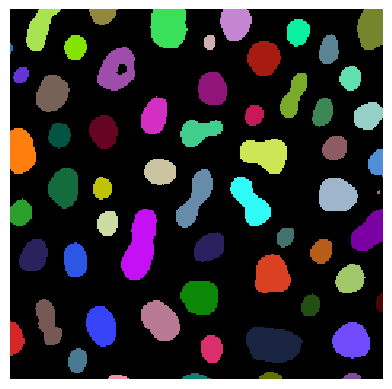

In [5]:
segmentation_result = classifier.predict(features=features, image=image)
stackview.imshow(segmentation_result, labels=True)

## Classifier statistics
After training, we can print out some statistics from the classifier. It gives us a table of used features and how important the features were for making the pixel classification decision.

In [6]:
shares, counts = classifier.statistics()

def colorize(styler):
    styler.background_gradient(axis=None, cmap="PiYG")
    return styler

df = pd.DataFrame(shares).T
df.style.pipe(colorize)

,0,1,2,3,4
original,0.138000,0.046423,0.042312,0.037281,0.062112
gaussian_blur=1,0.228000,0.092846,0.074303,0.105263,0.055901
difference_of_gaussian=1,0.000000,0.108828,0.095975,0.074561,0.086957
laplace_box_of_gaussian_blur=1,0.000000,0.105784,0.089783,0.081140,0.099379
gaussian_blur=5,0.096000,0.064688,0.118679,0.096491,0.130435
difference_of_gaussian=5,0.254000,0.182648,0.112487,0.120614,0.118012
laplace_box_of_gaussian_blur=5,0.209000,0.194064,0.121775,0.118421,0.124224
gaussian_blur=25,0.004000,0.061644,0.113519,0.127193,0.080745
difference_of_gaussian=25,0.031000,0.072298,0.122807,0.127193,0.130435
laplace_box_of_gaussian_blur=25,0.040000,0.070776,0.108359,0.111842,0.111801


In this visualization you can see that the features `gaussian_blur=1`, `difference_of_gaussian=5` and `laplace_box_of_gaussian_blur=5` make about 65% of the decision. On the first level (level `0`). If these three features are crucial, we can train another classifier that only takes these features into account. Furthermore, we see that the share the features are used on the higher three depth levels is more uniformly distributed. These levels may not make a big difference when classifying pixels. The next classifier we train, we can train with lower `max_depth`.

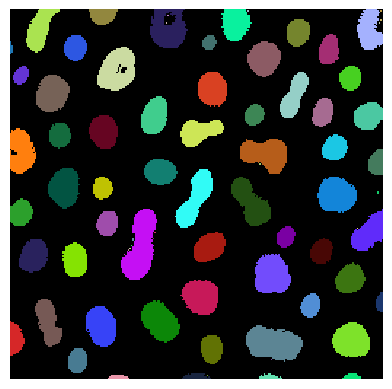

In [7]:
# define features
features = "gaussian_blur=1 difference_of_gaussian=5 laplace_box_of_gaussian_blur=5"

# this is where the model will be saved
cl_filename = 'data/blobs_object_segmenter_2.cl'

apoc.erase_classifier(cl_filename)
classifier = apoc.ObjectSegmenter(opencl_filename=cl_filename, 
                           positive_class_identifier=2, 
                           max_depth=3,
                           num_ensembles=1000)
classifier.train(features, manual_annotation, image)

segmentation_result = classifier.predict(features=features, image=image)
stackview.imshow(segmentation_result, labels=True)

The new classifier still produces a very similar result. It takes less features into account, which makes it faster, but potentially also less robust again differences between images and imaging conditions. We just take another look at the classifier statistics:

In [8]:
shares, counts = classifier.statistics()
df = pd.DataFrame(shares).T
df.style.pipe(colorize)

,0,1,2
gaussian_blur=1,0.331000,0.349194,0.344620
difference_of_gaussian=5,0.356000,0.329839,0.337096
laplace_box_of_gaussian_blur=5,0.313000,0.320968,0.318284


For demonstration purposes, we will now train another classifier on features that we not relevant accoring to the visualization above.

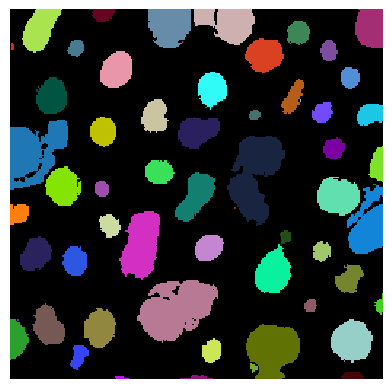

In [9]:
# define features
features = "difference_of_gaussian=1 laplace_box_of_gaussian_blur=1 gaussian_blur=5 gaussian_blur=25 difference_of_gaussian=25 laplace_box_of_gaussian_blur=25"

# this is where the model will be saved
cl_filename = 'data/blobs_object_segmenter_3.cl'

apoc.erase_classifier(cl_filename)
classifier = apoc.ObjectSegmenter(opencl_filename=cl_filename, 
                           positive_class_identifier=2, 
                           max_depth=3,
                           num_ensembles=1000)
classifier.train(features, manual_annotation, image)

segmentation_result = classifier.predict(features=features, image=image)
stackview.imshow(segmentation_result, labels=True)

## Exercise
Use the dataset human_mitosis and create a workflow for segmenting nuclei which uses a pixel classifier or object segmenter. Hint: When drawing annotations using napari or `stackview.annotate`, make sure you draw thin lines in gaps between dense nuclei.  

StackViewNDArray([[ 8,  8,  8, ..., 63, 78, 75],
                  [ 8,  8,  7, ..., 67, 71, 71],
                  [ 9,  8,  8, ..., 53, 64, 66],
                  ...,
                  [ 8,  9,  8, ..., 17, 24, 59],
                  [ 8,  8,  8, ..., 17, 22, 55],
                  [ 8,  8,  8, ..., 16, 18, 38]], dtype=uint8)
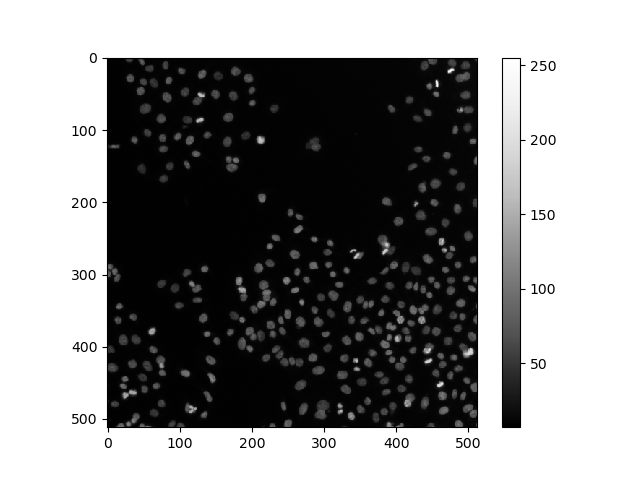
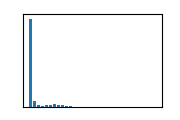

In [10]:
image2 = human_mitosis()
stackview.insight(image2)